# Linear Regression Model

This is where I work with the merged dataframe to fit a linear regression model in order to predict the opening box office gross

In [161]:
# all of the imports
import pandas as pd
import numpy as np
import pickle 
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
# from sklearn.preprocessing import power_transform
from scipy.stats import boxcox
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
% matplotlib inline
%config InlineBackend.figure_format = 'png'
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

import warnings
warnings.filterwarnings('ignore')

In [162]:
# Import merged dataframe
merged2 = pd.read_pickle('merged2.pkl')
merged2.head(7)

,movie_name,movie,op_gross,est_tick,date_time,theaters,tot_gross,unemp_rate,imdb,metacritic,...,year,Yviews_adj,Ylikes_adj,Ydis_adj,Ycom_adj,tick,act_gross,act_nmovies,dir_gross,dir_nmovies
0,The Hunger Games: Catching Fire,The Hunger Games: Catching Fire,158074286,19443331,2013-11-22,4163,424668047,6.9,7.5,76,...,2013,5649515.0,23726.0,632.0,4329.0,8.13,3333.4,56,1056.5,7
1,Frozen,Frozen,243390,29937,2013-11-22,1,400738009,6.9,7.5,74,...,2013,4249150.0,6715.0,1074.0,925.0,8.13,1774.2,19,230.0,3
2,Thor: The Dark World,Thor: The Dark World,85737841,10545859,2013-11-08,3841,206362140,6.9,7.0,54,...,2013,8467428.0,30885.0,1178.0,5576.0,8.13,2968.6,57,89.7,2
3,The Best Man Holiday,The Best Man Holiday,30107555,3703266,2013-11-15,2024,70525195,6.9,6.7,59,...,2013,454111.0,1194.0,72.0,172.0,8.13,1328.5,34,346.3,9
4,Last Vegas,Last Vegas,16334566,2009171,2013-11-01,3065,63914167,6.9,6.6,48,...,2013,382762.0,514.0,44.0,47.0,8.13,4458.3,81,843.5,10
5,Ender's Game,Ender's Game,27017351,3323167,2013-11-01,3407,61737191,6.9,6.7,51,...,2013,1673684.0,4379.0,288.0,1414.0,8.13,4902.1,52,0.0,0
6,Free Birds,Free Birds,15805237,1944063,2013-11-01,3736,55750480,6.9,5.9,38,...,2013,386277.0,945.0,77.0,130.0,8.13,2996.1,56,165.0,3


In [163]:
# add these columns to account for whether the actors/directors were identified
merged2["dirgross_bin"] = merged2.dir_gross.apply(lambda x: x/x if x > 0 else x)
merged2["actgross_bin"] = merged2.act_gross.apply(lambda x: x/x if x > 0 else x)
merged2.head()

,movie_name,movie,op_gross,est_tick,date_time,theaters,tot_gross,unemp_rate,imdb,metacritic,...,Ylikes_adj,Ydis_adj,Ycom_adj,tick,act_gross,act_nmovies,dir_gross,dir_nmovies,dirgross_bin,actgross_bin
0,The Hunger Games: Catching Fire,The Hunger Games: Catching Fire,158074286,19443331,2013-11-22,4163,424668047,6.9,7.5,76,...,23726.0,632.0,4329.0,8.13,3333.4,56,1056.5,7,1.0,1.0
1,Frozen,Frozen,243390,29937,2013-11-22,1,400738009,6.9,7.5,74,...,6715.0,1074.0,925.0,8.13,1774.2,19,230.0,3,1.0,1.0
2,Thor: The Dark World,Thor: The Dark World,85737841,10545859,2013-11-08,3841,206362140,6.9,7.0,54,...,30885.0,1178.0,5576.0,8.13,2968.6,57,89.7,2,1.0,1.0
3,The Best Man Holiday,The Best Man Holiday,30107555,3703266,2013-11-15,2024,70525195,6.9,6.7,59,...,1194.0,72.0,172.0,8.13,1328.5,34,346.3,9,1.0,1.0
4,Last Vegas,Last Vegas,16334566,2009171,2013-11-01,3065,63914167,6.9,6.6,48,...,514.0,44.0,47.0,8.13,4458.3,81,843.5,10,1.0,1.0


In [164]:
merged2.columns

Index(['movie_name', 'movie', 'op_gross', 'est_tick', 'date_time', 'theaters',
       'tot_gross', 'unemp_rate', 'imdb', 'metacritic', 'rated',
       'rotten_tomatoes', 'runtime', 'year', 'Yviews_adj', 'Ylikes_adj',
       'Ydis_adj', 'Ycom_adj', 'tick', 'act_gross', 'act_nmovies', 'dir_gross',
       'dir_nmovies', 'dirgross_bin', 'actgross_bin'],
      dtype='object')

In [165]:
#merged2.columns
#drop unnecessary/duplicate columns
merged2 = merged2.drop(["movie","movie_name","tick", "year",
                        "tot_gross","op_gross","date_time"],1)
merged2.head()

,est_tick,theaters,unemp_rate,imdb,metacritic,rated,rotten_tomatoes,runtime,Yviews_adj,Ylikes_adj,Ydis_adj,Ycom_adj,act_gross,act_nmovies,dir_gross,dir_nmovies,dirgross_bin,actgross_bin
0,19443331,4163,6.9,7.5,76,PG-13,89,146,5649515.0,23726.0,632.0,4329.0,3333.4,56,1056.5,7,1.0,1.0
1,29937,1,6.9,7.5,74,PG,90,102,4249150.0,6715.0,1074.0,925.0,1774.2,19,230.0,3,1.0,1.0
2,10545859,3841,6.9,7.0,54,PG-13,66,112,8467428.0,30885.0,1178.0,5576.0,2968.6,57,89.7,2,1.0,1.0
3,3703266,2024,6.9,6.7,59,R,70,123,454111.0,1194.0,72.0,172.0,1328.5,34,346.3,9,1.0,1.0
4,2009171,3065,6.9,6.6,48,PG-13,45,105,382762.0,514.0,44.0,47.0,4458.3,81,843.5,10,1.0,1.0


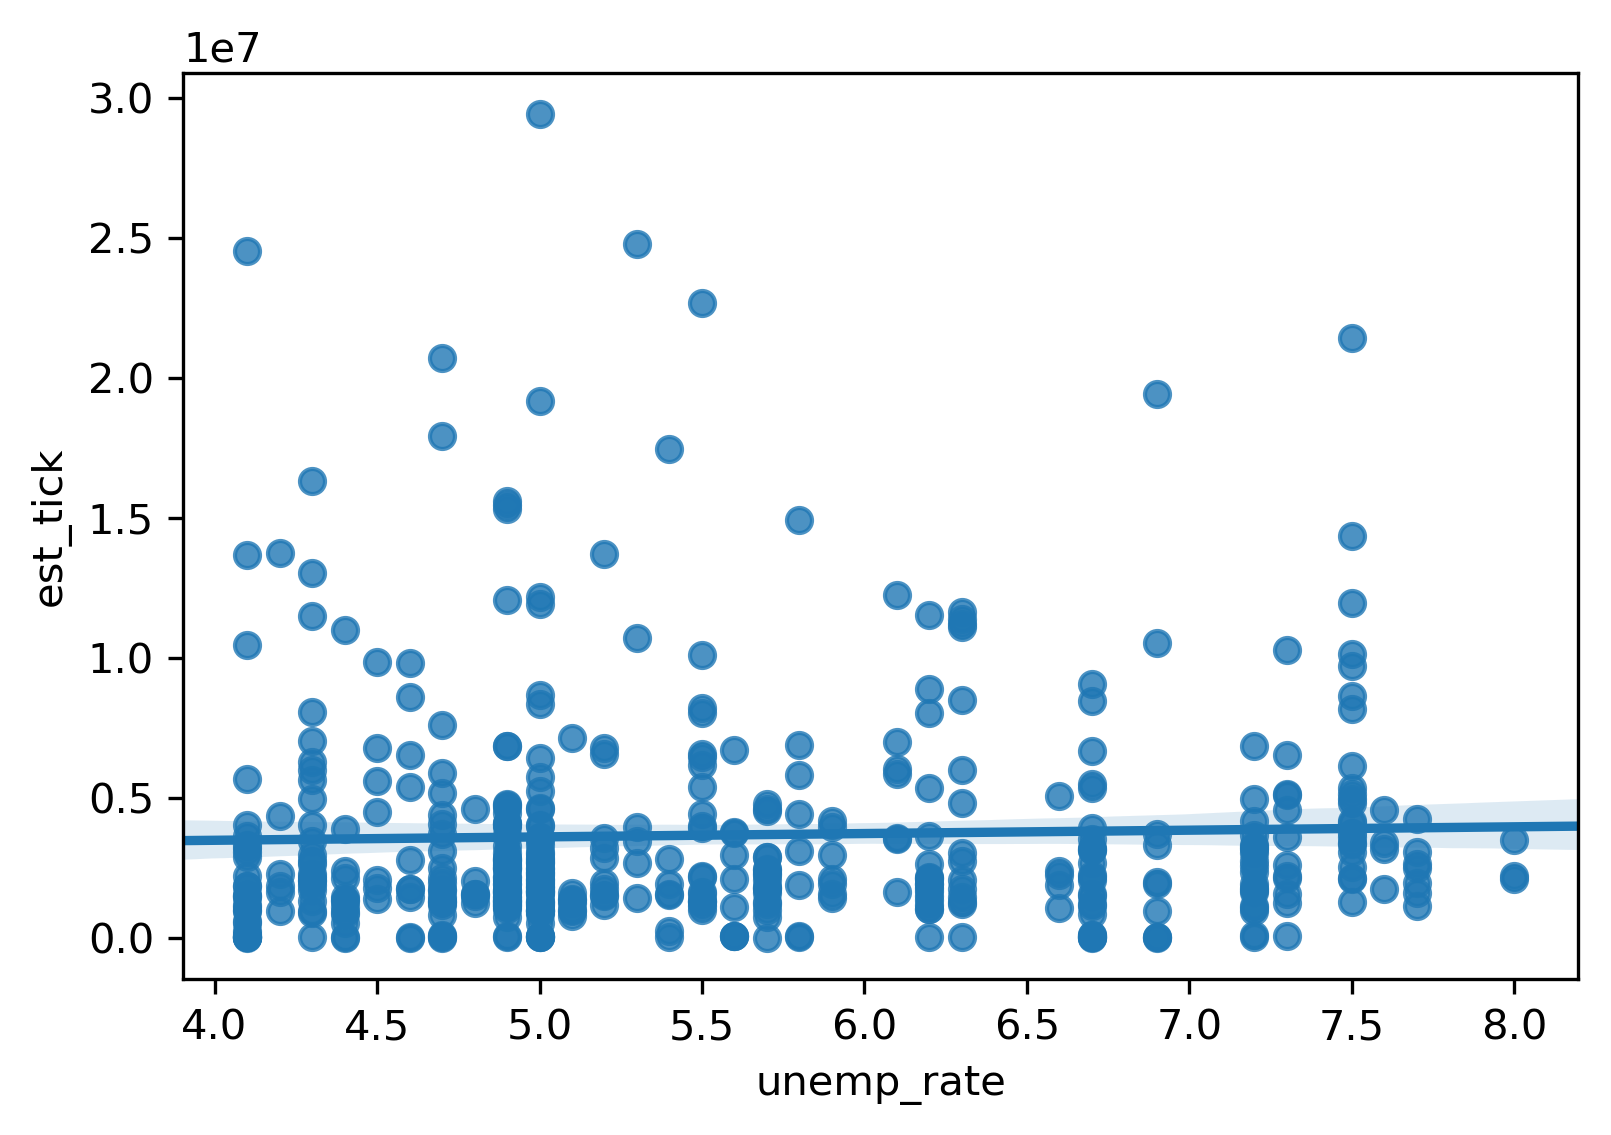

In [166]:
#sns.pairplot(merged2)
sns.regplot(merged2.unemp_rate, merged2.est_tick)


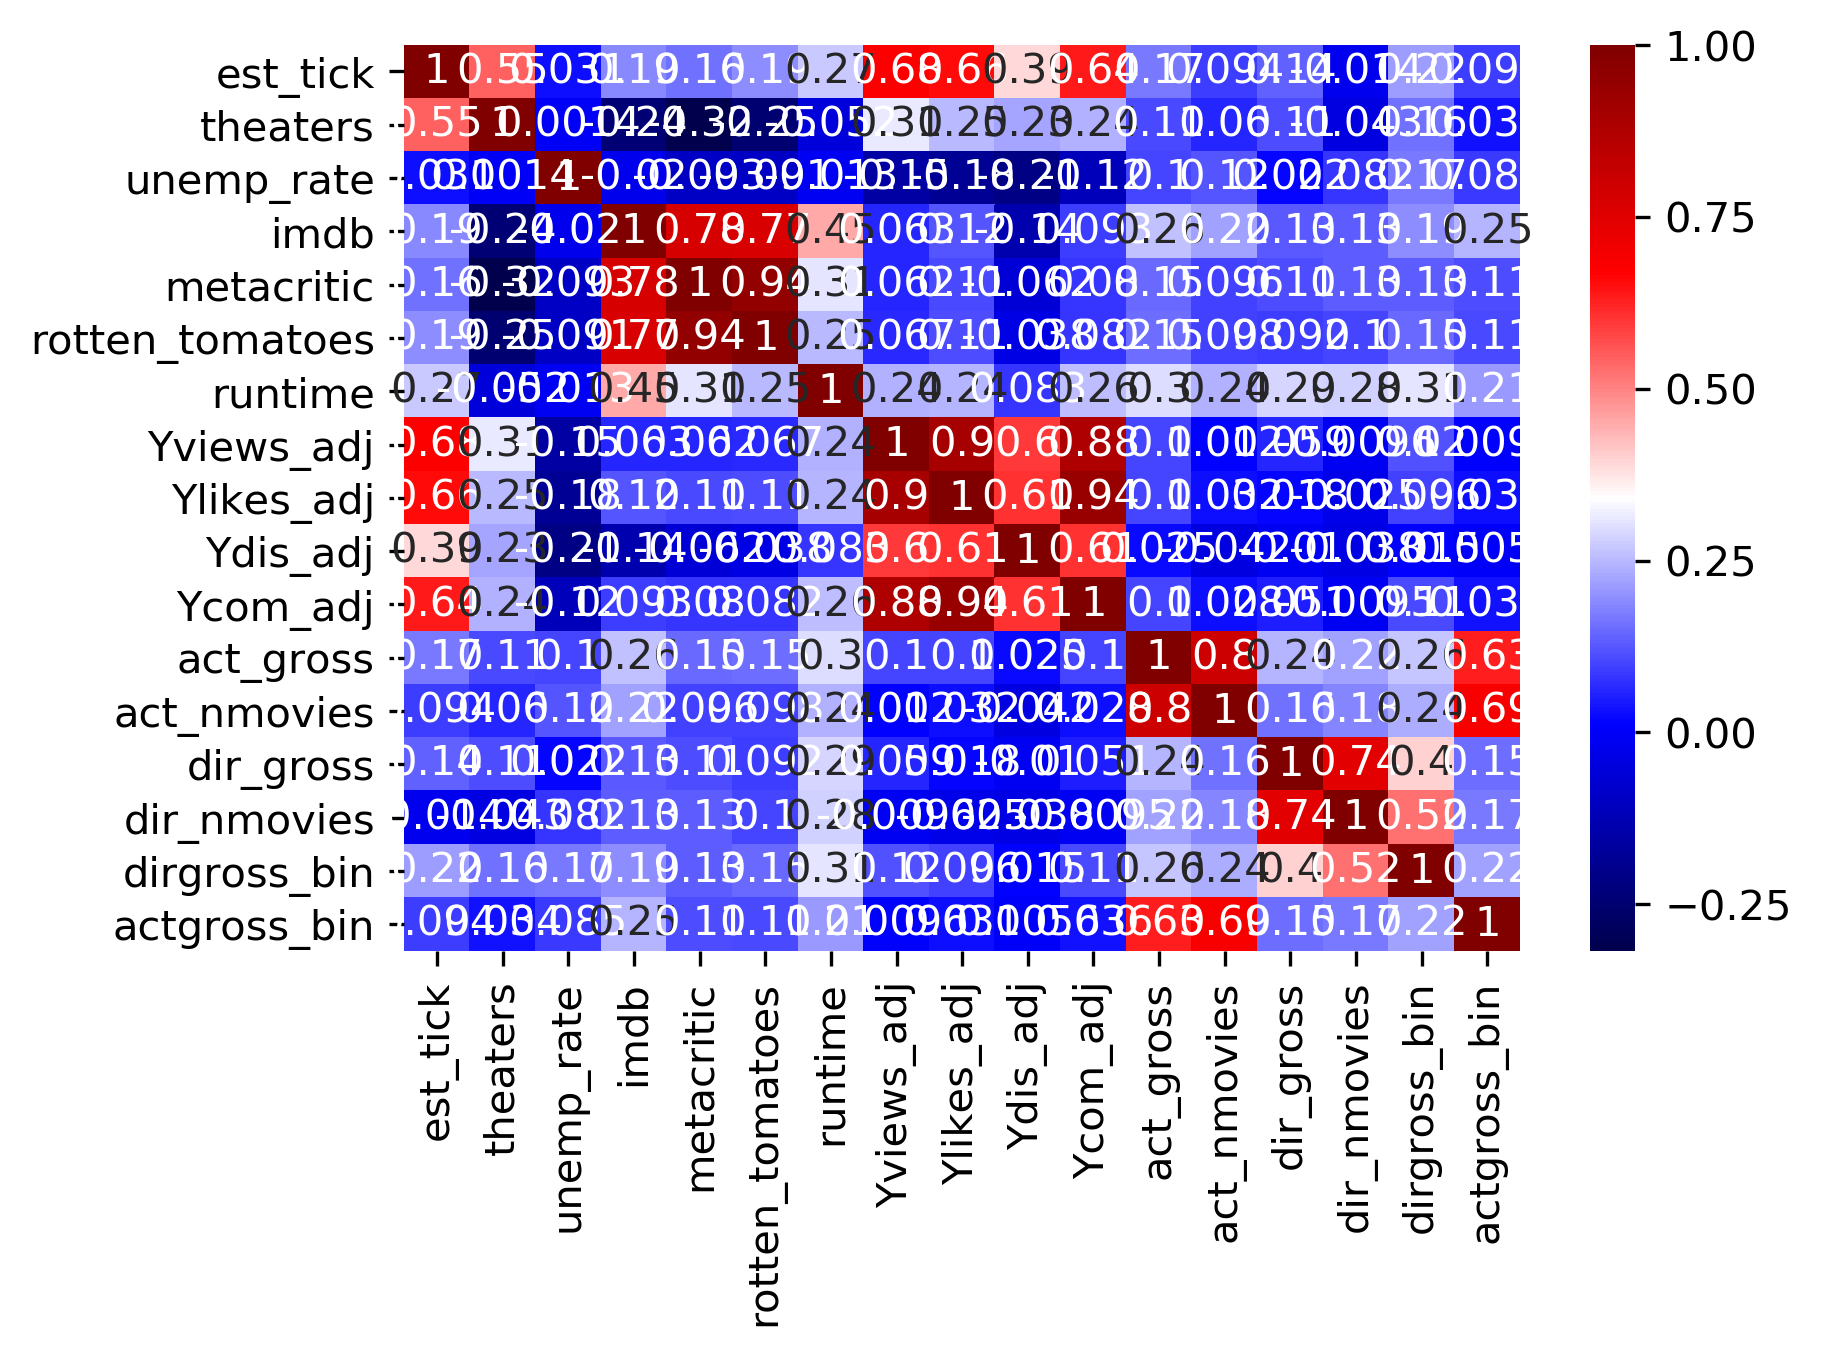

In [167]:
sns.heatmap(merged2.corr(), cmap = "seismic", annot=True)

In [168]:
merged3.columns

Index(['est_tick', 'theaters', 'unemp_rate', 'imdb', 'metacritic',
       'rotten_tomatoes', 'runtime', 'Yviews_adj', 'Ylikes_adj', 'Ydis_adj',
       'Ycom_adj', 'act_gross', 'act_nmovies', 'dir_gross', 'dir_nmovies',
       'dirgross_bin', 'actgross_bin', 'Intercept', 'rated[T.PG]',
       'rated[T.PG-13]', 'rated[T.R]'],
      dtype='object')

In [169]:
X = patsy.dmatrix('rated',data=merged2,return_type='dataframe')
X.head()

,Intercept,rated[T.PG],rated[T.PG-13],rated[T.R]
0,1.0,0.0,1.0,0.0
1,1.0,1.0,0.0,0.0
2,1.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0


In [170]:
merged3 = merged2.join(X)
merged3 = merged3.drop(["rated"],1)
merged3.head()

,est_tick,theaters,unemp_rate,imdb,metacritic,rotten_tomatoes,runtime,Yviews_adj,Ylikes_adj,Ydis_adj,...,act_gross,act_nmovies,dir_gross,dir_nmovies,dirgross_bin,actgross_bin,Intercept,rated[T.PG],rated[T.PG-13],rated[T.R]
0,19443331,4163,6.9,7.5,76,89,146,5649515.0,23726.0,632.0,...,3333.4,56,1056.5,7,1.0,1.0,1.0,0.0,1.0,0.0
1,29937,1,6.9,7.5,74,90,102,4249150.0,6715.0,1074.0,...,1774.2,19,230.0,3,1.0,1.0,1.0,1.0,0.0,0.0
2,10545859,3841,6.9,7.0,54,66,112,8467428.0,30885.0,1178.0,...,2968.6,57,89.7,2,1.0,1.0,1.0,0.0,1.0,0.0
3,3703266,2024,6.9,6.7,59,70,123,454111.0,1194.0,72.0,...,1328.5,34,346.3,9,1.0,1.0,1.0,0.0,0.0,1.0
4,2009171,3065,6.9,6.6,48,45,105,382762.0,514.0,44.0,...,4458.3,81,843.5,10,1.0,1.0,1.0,0.0,1.0,0.0


In [171]:
merged3["tick_log"] = np.log(merged3.est_tick)

In [172]:
merged3.isnull().sum()

est_tick           0
theaters           0
unemp_rate         0
imdb               0
metacritic         0
rotten_tomatoes    0
runtime            0
Yviews_adj         0
Ylikes_adj         0
Ydis_adj           0
Ycom_adj           0
act_gross          0
act_nmovies        0
dir_gross          0
dir_nmovies        0
dirgross_bin       0
actgross_bin       0
Intercept          0
rated[T.PG]        0
rated[T.PG-13]     0
rated[T.R]         0
tick_log           0
dtype: int64

In [173]:
y = merged3.tick_log
X = merged3.drop(['tick_log','est_tick'],1)

#model= LinearRegression()
#fit = model.fit(X,y)

In [190]:
# Split train test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

In [191]:
degree = 2
est = make_pipeline(PolynomialFeatures(degree),LinearRegression())
est.fit(X_train,y_train)
est.score(X_train,y_train)

0.9436733146354955

In [179]:
lr = LinearRegression()
# INSTRUCTOR NOTE: Run this multiple times to show the variation
# Split the data into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# Fit the model against the training data
lr.fit(X_train, y_train)
# Evaluate the model against the testing data
lr.score(X_test, y_test)

0.8378891076276574

In [ ]:
# Create your model
model = sm.OLS(y,X)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()